# 迁移学习微调训练水果识别模型


## 导入工具包

In [3]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

## 获取计算硬件

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


## 图像预处理

In [5]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入图像分类数据集

In [6]:
# 数据集文件夹路径
dataset_dir = 'dataset'

In [9]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'test')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 dataset/train
测试集路径 dataset/test


In [10]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [11]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 4035
类别个数 2
各类别名称 ['freshapples', 'rottenapples']


In [12]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 996
类别个数 2
各类别名称 ['freshapples', 'rottenapples']


## 类别和索引号 一一对应

In [13]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [14]:
class_names

['freshapples', 'rottenapples']

In [15]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'freshapples': 0, 'rottenapples': 1}

In [16]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [17]:
idx_to_labels

{0: 'freshapples', 1: 'rottenapples'}

In [18]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

## 定义数据加载器DataLoader

In [19]:
from torch.utils.data import DataLoader

In [20]:
BATCH_SIZE = 4

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

## 查看一个batch的图像和标注

In [21]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [22]:
images.shape

torch.Size([4, 3, 224, 224])

In [23]:
labels

tensor([0, 1, 0, 1])

## 可视化一个batch的图像和标注

In [24]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [26]:
images[0].shape

(3, 224, 224)

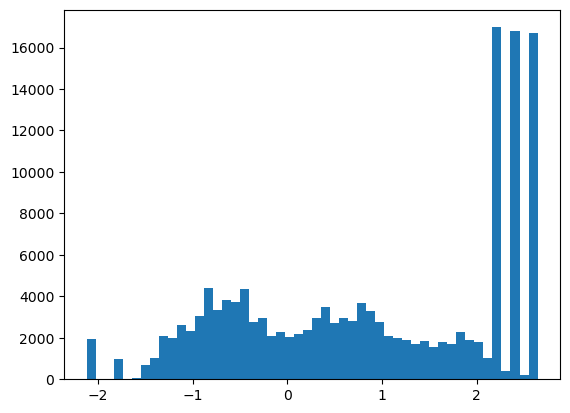

In [28]:
plt.hist(images[0].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


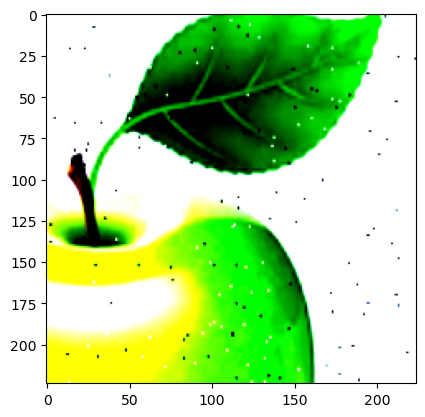

In [29]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)


In [30]:
label = labels[idx].item()

In [31]:
label

0

In [32]:
pred_classname = idx_to_labels[label]

In [33]:
pred_classname

'freshapples'

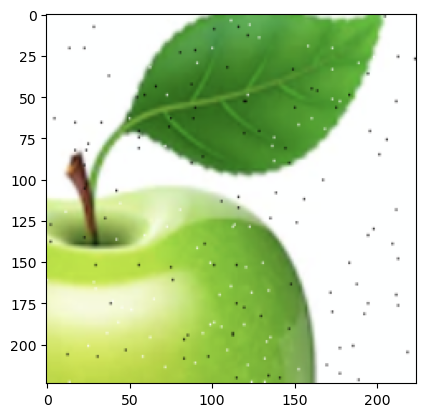

In [34]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.show()

## 导入训练需使用的工具包

In [35]:
from torchvision import models
import torch.optim as optim

### 只微调训练模型最后一层（全连接分类层）

In [36]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

In [38]:
model.fc
# 语义特征512，输出2种
# 只需将其原本到一千多种输出改成我们的两种输出即可
# 我们的数据集分布和imagenet数据集分布很像，只需fine- tuning即可

Linear(in_features=512, out_features=2, bias=True)

In [39]:
# 只微调训练最后一层全连接层的参数，其它层冻结
# 优化器选择adam
optimizer = optim.Adam(model.fc.parameters())

## 训练配置

In [40]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 6

## 模拟一个batch的训练

In [41]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [42]:
# 输入模型，执行前向预测
outputs = model(images)

In [43]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([4, 2])

In [44]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [45]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [46]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

In [47]:
preds

tensor([1, 1, 1, 1])

In [48]:
labels

tensor([1, 1, 1, 0])

## 运行完整训练

In [49]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获得一个 batch 的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████| 6/6 [26:29<00:00, 264.99s/it]


## 在测试集上初步测试

In [50]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|█████████████████████████████████████████| 249/249 [00:36<00:00,  6.90it/s]

测试集上的准确率为 97.289 %


In [ ]:
# 训练开始之前，记录

In [ ]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [ ]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [ ]:
df_train_log

In [ ]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [ ]:
df_test_log

## 保存模型

In [51]:
torch.save(model, 'checkpoints/apple_freshness_zhou.pth')